In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# lets have a quick look at the data file structure
base_dir = '/kaggle/input/rice-leaf-diseases/rice_leaf_diseases'
for directory in os.listdir(base_dir):
    print(f'The parent directory is {base_dir}/{directory}')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The parent directory is /kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot
The parent directory is /kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight
The parent directory is /kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Leaf smut


In [2]:
import tensorflow as tf
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_available

True

In [3]:
# function to find the number of categories in 
def calculate_categories_num(folder_dir):
    return len(os.listdir(folder_dir))

In [4]:
# calculate the number of categories
calculate_categories_num(base_dir)

3

In [5]:
# This means our dataset contains 3 different categories that need to be classified
# lets print this categories out
def print_categories(folder_dir):
    categories = []
    for direc in os.listdir(folder_dir):
        categories.append(direc)
        print(direc)
    return categories

In [6]:
all_cat = print_categories(base_dir)

Brown spot
Bacterial leaf blight
Leaf smut


In [7]:
# we would now find the number of images in each category and try to plot how much percentage they make up from the total number 
# of images in the dataset
def categories_percentage(folder_dir):
    cat_percent_dict = {}
    for direc in os.listdir(folder_dir):
            cat_percent_dict[f'{direc}'] = len(os.listdir(os.path.join(f'{folder_dir}',f'{direc}')))
    return cat_percent_dict

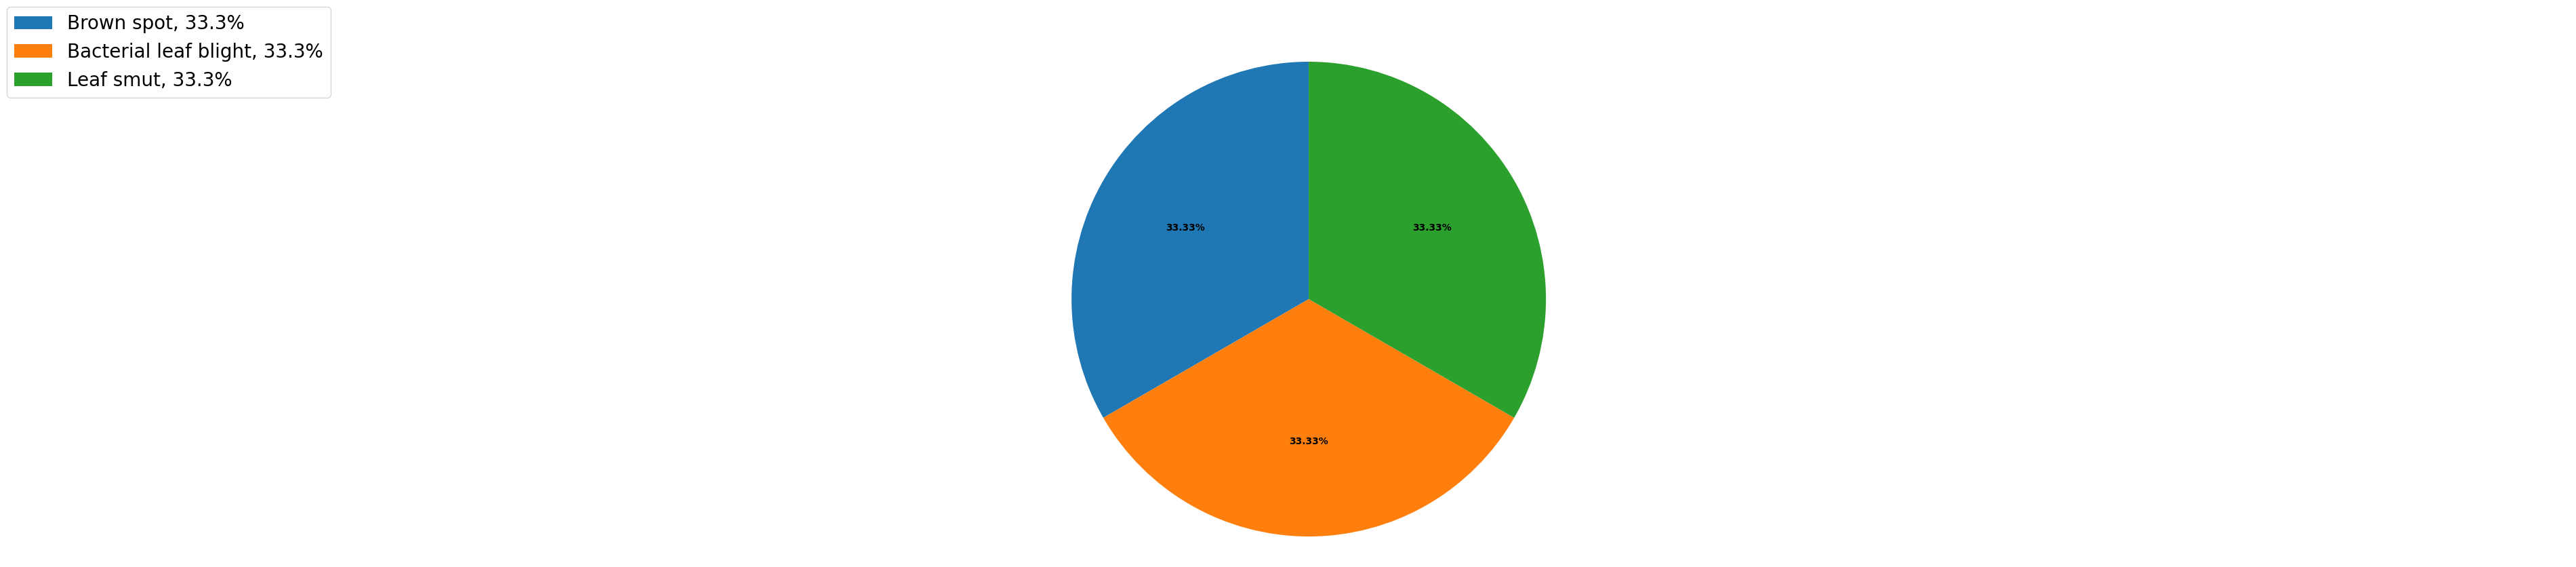

In [8]:
import matplotlib.pyplot as plt
import seaborn

train_cat_num = categories_percentage(base_dir)
def autopct_generator(limit):
    """Remove percent on small slices."""
    def inner_autopct(pct):
        return ('%.2f%%' % pct) if pct > limit else ''
    return inner_autopct

#define Seaborn color palette to use
#palette_color = seaborn.color_palette('bright')
fig1, ax1 = plt.subplots(figsize=(6, 5))
box = box = ax1.get_position()
ax1.set_position([box.x0, box.y0-box.height, box.width * 8, box.height*2])
# plotting data on chart
_, _, autotexts = ax1.pie(
    train_cat_num.values(), autopct=autopct_generator(7), startangle=90, radius=4000)
for autotext in autotexts:
    autotext.set_weight('bold')
ax1.axis('equal')
total = sum(train_cat_num.values())
plt.legend(
    loc='upper left',
    labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100) for l, s in zip(train_cat_num.keys(), train_cat_num.values())],
    prop={'size': 20},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

In [9]:
CLASS_NAMES = all_cat.copy()
#initialising necessary properties
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(10000/BATCH_SIZE)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
    validation_split=0.2,
        horizontal_flip=True)

train_generator = datagen.flow_from_directory(
    base_dir,
    batch_size=BATCH_SIZE,
        shuffle=True,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        classes = list(CLASS_NAMES),) 

# validation data generator
validation_generator = datagen.flow_from_directory(
     base_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        classes = list(CLASS_NAMES),
        batch_size=BATCH_SIZE,
        #subset='training'
)

Found 120 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


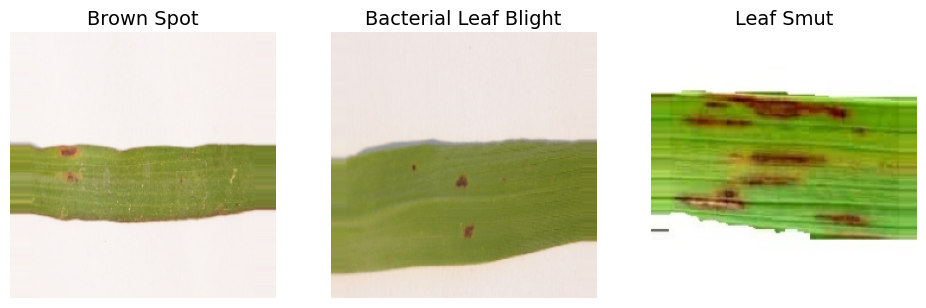

In [11]:
#vizualise the loaded images
def show_batch(image_batch, label_batch):
      fig = plt.figure(figsize=(20,20))
      fig.patch.set_facecolor('white')
      for n in range(3):
          ax = plt.subplot(5,5,n+1)
          plt.imshow(image_batch[n])
          plt.title(CLASS_NAMES[n].title(), fontsize=14)
          plt.axis('off')
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

In [12]:
#import model 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [13]:
#initialise base model
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
base_model = MobileNetV2(input_shape=IMG_SHAPE, input_tensor=None,
                                                include_top=False, 
                                                weights='imagenet')
# make the base feature extraction model trainable
base_model.trainable = True

9406464/9406464 [==============================] - 0s 0us/step


In [14]:
#define model
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(40, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 320)               409920    
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 40)                12840     
                                                                 
 dropout_1 (Dropout)         (None, 40)                0

In [15]:
epochs = 3

# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)

#  Save best model every epoch
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('.')
#fit the model
history = model.fit(train_generator, 
                    epochs=epochs,
                    validation_data = validation_generator,
                    callbacks=[early_stopper, reduce_lr,model_checkpoint])

Epoch 1/3


/opt/conda/lib/python3.7/site-packages/keras/backend.py:5535: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "categorical_crossentropy"


4/4 [==============================] - 53s 11s/step - loss: 1.3928 - accuracy: 0.3000 - val_loss: 1.3262 - val_accuracy: 0.3583 - lr: 0.0010
Epoch 2/3
4/4 [==============================] - 32s 10s/step - loss: 1.0803 - accuracy: 0.4417 - val_loss: 1.1786 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 3/3
4/4 [==============================] - 33s 11s/step - loss: 0.8450 - accuracy: 0.6500 - val_loss: 1.0656 - val_accuracy: 0.4250 - lr: 0.0010


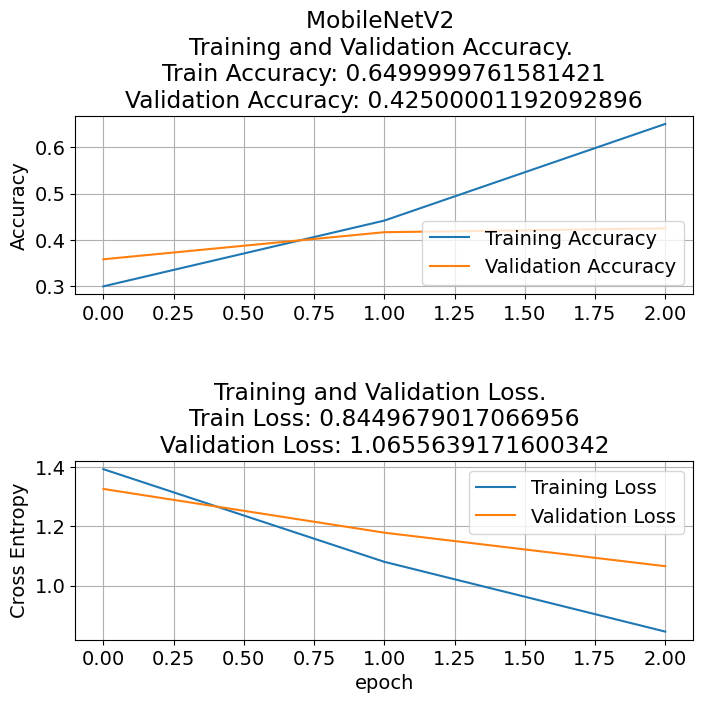

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [17]:
# save the model 
saved_model = tf.keras.models.load_model('.')
file_h5 = "rice_model_1.h5"
tf.keras.models.save_model(saved_model, file_h5)

In [18]:
# Tune some parts like learning rate and momentum
# momentum = 0.8
# learning_rate = 0.002
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.8), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy'])

In [19]:
history = model.fit(train_generator, 
                    epochs=epochs,
                    validation_data = validation_generator,
                    callbacks=[early_stopper, reduce_lr,model_checkpoint])

Epoch 1/3


/opt/conda/lib/python3.7/site-packages/keras/backend.py:5535: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "categorical_crossentropy"


4/4 [==============================] - 46s 11s/step - loss: 0.8171 - accuracy: 0.6250 - val_loss: 1.0760 - val_accuracy: 0.4750 - lr: 0.0020
Epoch 2/3
4/4 [==============================] - 32s 10s/step - loss: 0.5671 - accuracy: 0.8000 - val_loss: 1.0586 - val_accuracy: 0.5083 - lr: 0.0020
Epoch 3/3
4/4 [==============================] - 32s 10s/step - loss: 0.5003 - accuracy: 0.8583 - val_loss: 1.0148 - val_accuracy: 0.5833 - lr: 0.0020


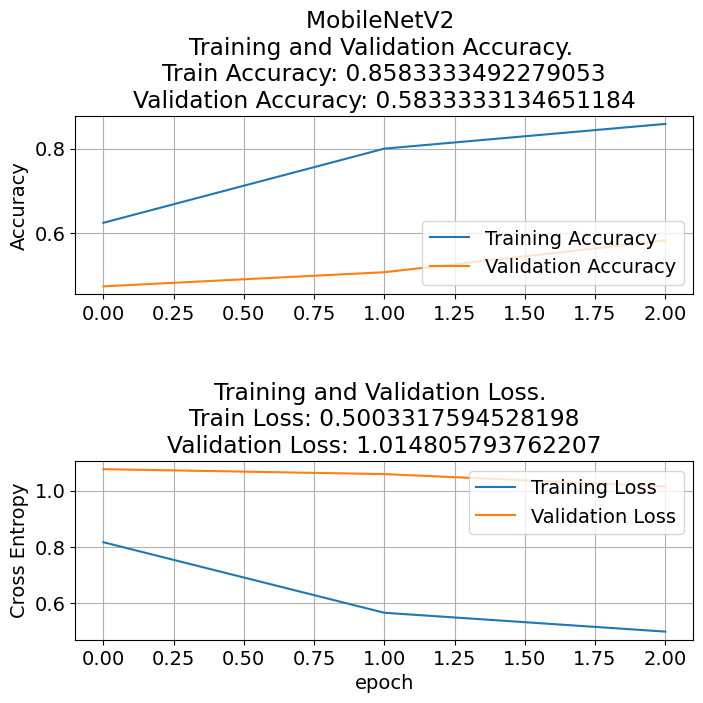

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [21]:
# Tune some parts like learning rate and momentum
# momentum = 0.8
# learning_rate = 0.002
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.8), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy'])

In [22]:
history = model.fit(train_generator, 
                    epochs=epochs,
                    validation_data = validation_generator,
                    callbacks=[early_stopper, reduce_lr,model_checkpoint])

Epoch 1/3


/opt/conda/lib/python3.7/site-packages/keras/backend.py:5535: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "categorical_crossentropy"


4/4 [==============================] - 45s 11s/step - loss: 0.3730 - accuracy: 0.8833 - val_loss: 0.9287 - val_accuracy: 0.5583 - lr: 0.0020
Epoch 2/3
4/4 [==============================] - 33s 10s/step - loss: 0.3513 - accuracy: 0.9000 - val_loss: 0.9220 - val_accuracy: 0.5833 - lr: 0.0020
Epoch 3/3
4/4 [==============================] - 33s 11s/step - loss: 0.3396 - accuracy: 0.8833 - val_loss: 0.9035 - val_accuracy: 0.5750 - lr: 0.0020


In [23]:
# save the model 
saved_model = tf.keras.models.load_model('.')
file_h5 = "rice_model_2.h5"
tf.keras.models.save_model(saved_model, file_h5)

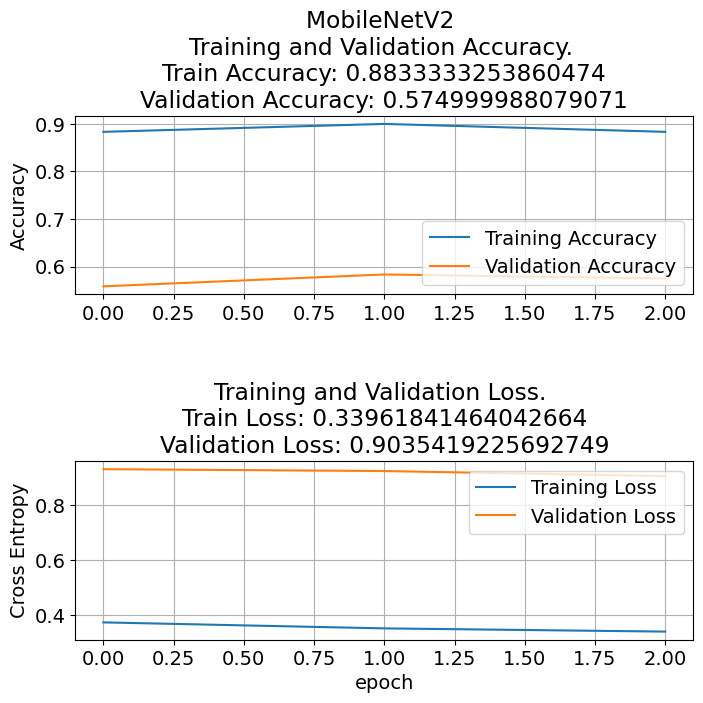

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [25]:
# Tune some parts like learning rate and momentum
# momentum = 0.7
# learning_rate = 0.003
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.003, momentum=0.7), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy'])

In [26]:
history = model.fit(train_generator, 
                    epochs=epochs,
                    validation_data = validation_generator,
                    callbacks=[early_stopper, reduce_lr,model_checkpoint])

Epoch 1/3


/opt/conda/lib/python3.7/site-packages/keras/backend.py:5535: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "categorical_crossentropy"


4/4 [==============================] - 47s 11s/step - loss: 0.2649 - accuracy: 0.9333 - val_loss: 0.9195 - val_accuracy: 0.5833 - lr: 0.0030
Epoch 2/3
4/4 [==============================] - 34s 11s/step - loss: 0.2191 - accuracy: 0.9500 - val_loss: 0.8518 - val_accuracy: 0.6333 - lr: 0.0030
Epoch 3/3
4/4 [==============================] - 32s 10s/step - loss: 0.1662 - accuracy: 0.9750 - val_loss: 0.8196 - val_accuracy: 0.6333 - lr: 0.0030


In [27]:
# save the model 
saved_model = tf.keras.models.load_model('.')
file_h5 = "rice_model_3.h5"
tf.keras.models.save_model(saved_model, file_h5)

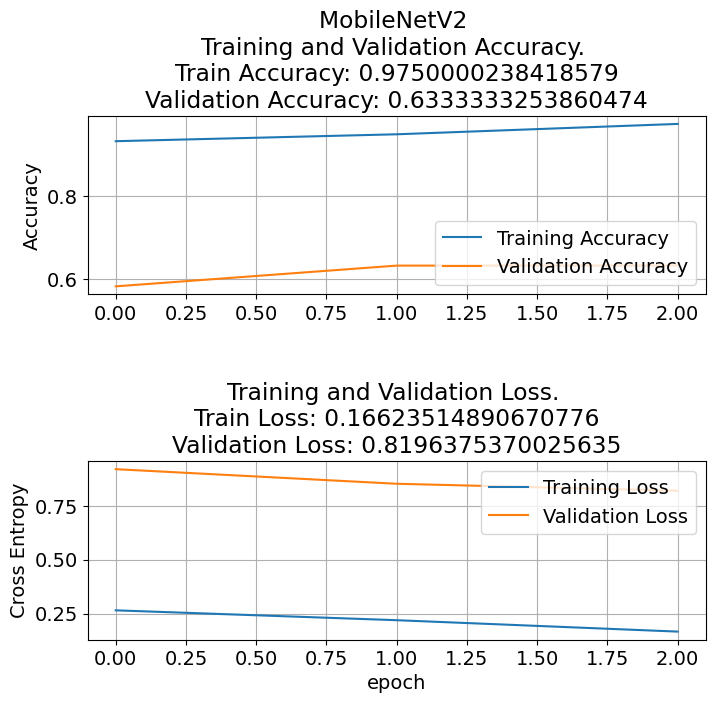

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()